In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/x.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CM

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.6.4
Numpy version:  1.21.6
Pandas version:  1.3.5
Scikit-learn version:  1.0.2


In [3]:
columns=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21"]
train_data = pd.read_csv("../input/nasa-cmaps/CMaps/train_FD001.txt", sep= "\s+", header = None,names=columns )
train_data. head() 

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


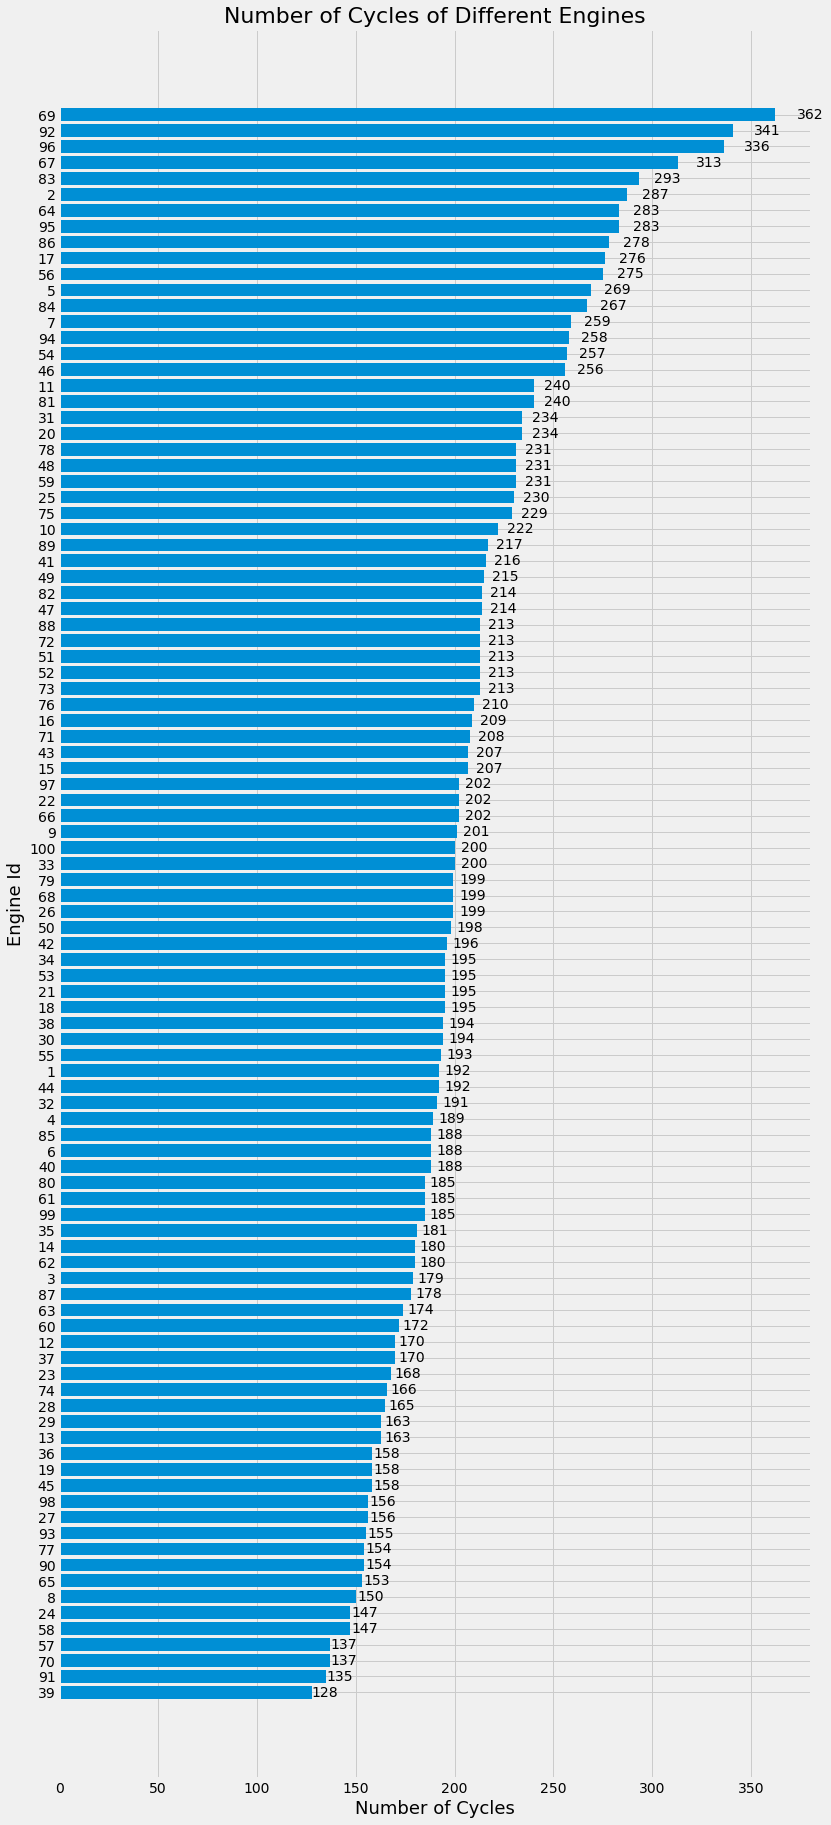

In [4]:
cnt_train=train_data[["id", "cycle"]].groupby("id").max().sort_values(by="cycle", ascending=True)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.cycle.values)

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12, 30))
rects = ax.barh(cnt_ind, cnt_val)
ax.set_title("Number of Cycles of Different Engines", fontsize=22)
ax.set_ylabel("Engine Id", fontsize=18)
ax.set_xlabel("Number of Cycles", fontsize=18)
ax.grid(True)

for rect in rects:
    width = rect.get_width()
    plt.text(1.05*rect.get_width(), rect.get_y()+0.5*rect.get_height(),
             '%d' % int(width),
             ha='center', va='center')

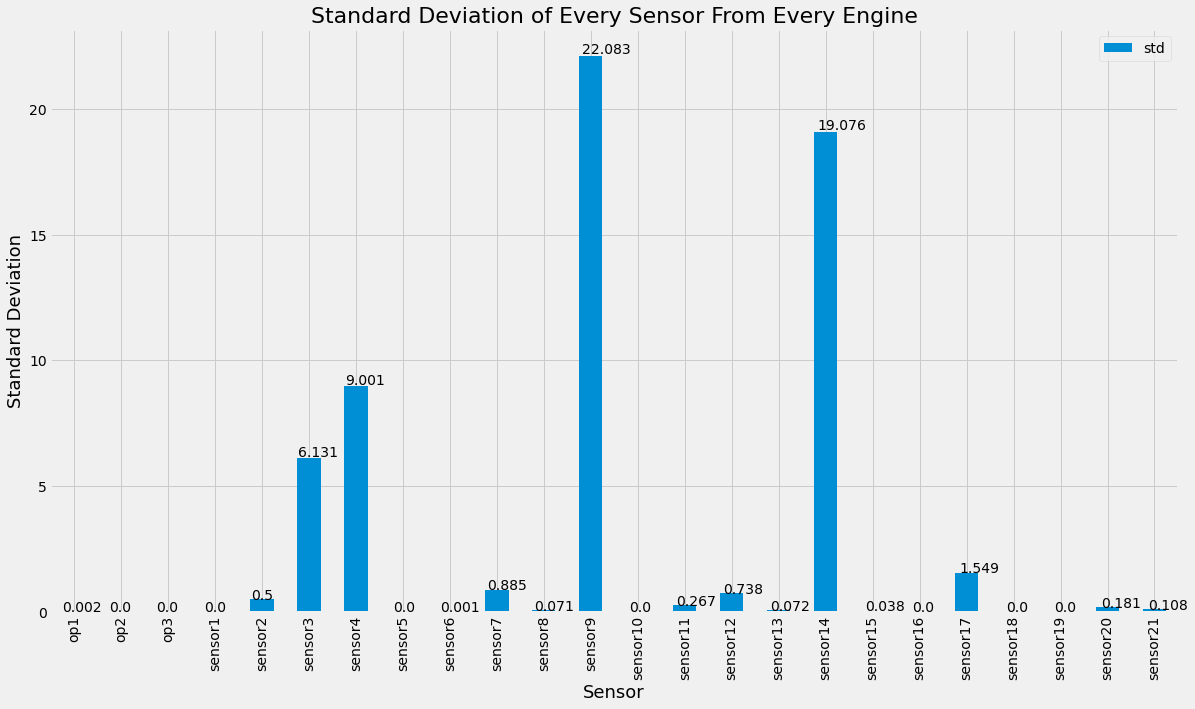

In [5]:
subset_stats = train_data.agg(['mean', 'std']).T[2:]
ax = subset_stats.plot.bar(figsize=(18,10), 
                           y="std")
ax.set_title("Standard Deviation of Every Sensor From Every Engine", fontsize=22)
ax.set_xlabel("Sensor", fontsize=18)
ax.set_ylabel("Standard Deviation", fontsize=18)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

In [6]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [7]:
test_data = pd.read_csv("../input/nasa-cmaps/CMaps/test_FD001.txt", sep = "\s+", header = None,names=columns )
true_rul = pd.read_csv("../input/nasa-cmaps/CMaps/RUL_FD001.txt", sep = '\s+', header = None)


In [8]:
window_length = 30
shift = 1
early_rul = 125          
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []
columns_to_be_dropped =['id','op1','op2','op3', 'sensor1', 'sensor5', 'sensor6','sensor7','sensor10',
                 'sensor16', 'sensor18', 'sensor19']

train_data_first_column = train_data['id']
test_data_first_column = test_data['id']

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


In [9]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data)).batch(128).prefetch(tf.data.AUTOTUNE)


2022-08-17 14:04:05.274527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 14:04:05.393757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 14:04:05.394797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 14:04:05.397338: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
class Seq2SeqEncoder(tf.keras.layers.Layer):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs): 
        super().__init__(*kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
    
    def call(self, X, *args, **kwargs):
        # The input `X` shape: (`batch_size`, `num_steps`, `num_features`)
        output = self.rnn(X, **kwargs) # Shape of output: (batch_size, num_steps, num_hiddens)
        state = output[1:]                        # Shape of state: (batch_size, num_hiddens)
        return (output[0], state)

In [11]:
class AdditiveAttentionForSeq(tf.keras.layers.Layer):
    def __init__(self, attention_size, **kwargs):
        super().__init__(**kwargs)
        self.attention = tf.keras.layers.Dense(attention_size)
        
    def call(self, state, encoder_outputs):
        # Shape of encocder_outputs: (batch_size, num_steps, hidden_dims)
        # Shape of state: (batch_size, hidden_dims)
        seq_len = encoder_outputs.shape[1]
        # Hidden states of stacked GRU are first averaged before computing attention weights as done below
        averaged_state = tf.reduce_mean(tf.stack(state, axis = 1), axis = 1)
        state_rep = tf.repeat(tf.expand_dims(averaged_state, axis = 1), repeats = seq_len, axis = 1)
        concat = tf.concat((state_rep, encoder_outputs), axis = -1)
        scores = tf.nn.tanh(self.attention(concat))  # Shape of score: (batch_size, num_steps, attention_size)
        # Shape of attention_weights: (batch_size, num_steps)
        attention_weights = tf.nn.softmax(tf.reduce_sum(scores, axis = -1), axis = -1) 
        return tf.matmul(tf.expand_dims(attention_weights, axis = 1), encoder_outputs)

In [12]:
class Seq2SeqAttentionDecoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(num_hiddens, dropout = dropout)
                                                                        for _ in range(num_layers)]),
                                       return_sequences = True, return_state = True)
        self.attention = AdditiveAttentionForSeq(attention_size = 32)
        self.dense = tf.keras.layers.Dense(1)
        
    def init_state(self, enc_outputs, *args):
        outputs, hidden_state = enc_outputs
        return (outputs, hidden_state)
    
    
    def call(self, dec_input, state, **kwargs):
        # Shape of dec_input: (batch_size, 1, num_features)
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        enc_outputs, enc_hidden_state = state
        # shape of context: (batch_size, 1, hidden_dims)
        context = self.attention(enc_hidden_state, enc_outputs)
        rnn_input = tf.concat((dec_input, context), axis = -1) # Shape of rnn_input: (batch_size, 1, (num_features + hidden_dims))
        rnn_output = self.rnn(rnn_input, enc_hidden_state, **kwargs)
        # Shape of rnn_output[0]: (batch_size, 1, num_hiddens)
        # Shape of rnn_output[1]: (num_layers, batch_size, num_hiddens)
        output = self.dense(tf.squeeze(rnn_output[0], axis = 1)) # Shape of output: (batch_sizef, 1)
        return output, rnn_output[1:]

In [13]:
class EncoderDecoder(tf.keras.Model):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, enc_X, dec_X, *args, **kwargs):
        enc_outputs = self.encoder(enc_X, *args, **kwargs)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state, **kwargs)
num_hiddens = 64
num_layers = 2
encoder = Seq2SeqEncoder(num_hiddens = num_hiddens, num_layers = num_layers)
decoder = Seq2SeqAttentionDecoder(num_hiddens = num_hiddens, num_layers = num_layers)

In [14]:
net = EncoderDecoder(encoder, decoder)

In [15]:
def train_seq2seq(net, data_iter, lr, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_object = tf.keras.losses.MeanSquaredError()
    for epoch in range(num_epochs):
        for batch in data_iter:
            X, Y = [x for x in batch]
            dec_input = X[:, -1, tf.newaxis]  # Only the last step of each input
            with tf.GradientTape() as tape:
                Y_hat, _ = net(X, dec_input, training = True)
                l = loss_object(Y, Y_hat)
            gradients = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
        print(f'epoch {epoch + 1}, loss {l}')
train_seq2seq(net, train_dataset, 0.001, 15)

epoch 1, loss 0.01263730600476265
epoch 2, loss 0.007534453179687262
epoch 3, loss 0.0058926427736878395
epoch 4, loss 0.005184058099985123
epoch 5, loss 0.004770273808389902
epoch 6, loss 0.004228200763463974
epoch 7, loss 0.0037849051877856255
epoch 8, loss 0.00353994220495224
epoch 9, loss 0.0033811326138675213
epoch 10, loss 0.0032226189505308867
epoch 11, loss 0.0030568712390959263
epoch 12, loss 0.0028813134413212538
epoch 13, loss 0.0027687184046953917
epoch 14, loss 0.002704187761992216
epoch 15, loss 0.00264218682423234


In [16]:
def predict_seq2seq(net, test_data_iter):
    final_preds = []
    for batch in test_data_iter:
        enc_outputs = net.encoder(batch, training = False)
        dec_state = net.decoder.init_state(enc_outputs)
        dec_X = batch[:, -1, tf.newaxis]
        Y_pred, _ = net.decoder(dec_X, dec_state, training = False)
        final_preds.append(Y_pred.numpy())
    return tf.squeeze(tf.concat(final_preds, axis = 0).numpy()).numpy()
rul_pred_unscaled = predict_seq2seq(net, test_dataset)
rul_pred = target_scaler.inverse_transform(rul_pred_unscaled.reshape(-1, 1)).reshape(-1)

In [17]:
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = mean_absolute_error(true_rul, mean_pred_for_each_engine)
print("RMSE: ", RMSE)
print("MAE: ", MAE)

RMSE:  15.41137908828148
MAE:  12.401487648487093


In [18]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last examples): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

RMSE (Taking only last examples):  14.83715575385637
MAE (Taking only last example):  11.406468176841736


S-score:  309.4596803461373


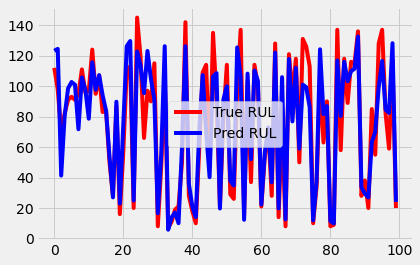

In [19]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()